In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))

2025-03-08 15:43:43.382833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-08 15:43:43.382851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


GPU disponibile: []


2025-03-08 15:43:45.986694: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-08 15:43:45.986717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: paolo-Katana-15-B13VFK
2025-03-08 15:43:45.986721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: paolo-Katana-15-B13VFK
2025-03-08 15:43:45.986810: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 560.35.3
2025-03-08 15:43:45.986827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  560.35.03  Release Build  (dvs-builder@U16-I1-N07-12-3)  Fri Aug 16 21:42:42 UTC 2024
GCC version:  gcc version 14.2.0 (Ubuntu 14.2.0-4ubuntu2) 
"


In [3]:
sys.path.append("../preprocessing")

In [4]:
import sampling as samp
import normalizzation as norm

In [5]:
sys.path.append("../models")

In [6]:
from lstm_model import LSTMModel

In [7]:
def load_partitions(root_path):
    file_names = ["X_train.csv", "X_test.csv", "X_val.csv", "y_train.csv", "y_test.csv", "y_val.csv"]
    datasets = [pd.read_csv(os.path.join(root_path, file)).values for file in file_names]
    return tuple(datasets)

In [8]:
# load data
X_train, X_test, X_val, y_train, y_test, y_val = load_partitions("../partitioning/npy/partitions_1")

# show partitions dimention
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (3583, 50), y_train shape: (3583, 1)
X_test shape: (768, 50), y_test shape: (768, 1)
X_val shape: (767, 50), y_val shape: (767, 1)


In [9]:
# Esempio di input_shape per dati sequenziali: (timesteps=100, features=10)
# input_shape = (50, 1)
window_lag = X_train.shape[1]
input_shape = (window_lag, 1)
print("input_shape: ", input_shape)

folder = "lstm_test_1"

# initialize model
lstm_model = LSTMModel(input_shape, folder)

# show model structure
lstm_model.summary()

input_shape:  (50, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 


2025-03-08 15:43:46.485300: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
# training model
lstm_model.train(X_train, y_train, epochs=100, batch_size=32, validation_data = (X_val, y_val))

Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.0154 - mae: 0.0955 - root_mean_squared_error: 0.1229
Epoch 1: val_loss improved from inf to 0.01290, saving model to lstm_test_1/best_model.h5
112/112 [==============================] - 5s 27ms/step - loss: 0.0154 - mae: 0.0955 - root_mean_squared_error: 0.1229 - val_loss: 0.0129 - val_mae: 0.0865 - val_root_mean_squared_error: 0.1121
Epoch 2/100
111/112 [============================>.] - ETA: 0s - loss: 0.0113 - mae: 0.0809 - root_mean_squared_error: 0.1049
Epoch 2: val_loss improved from 0.01290 to 0.00894, saving model to lstm_test_1/best_model.h5
112/112 [==============================] - 2s 19ms/step - loss: 0.0112 - mae: 0.0808 - root_mean_squared_error: 0.1047 - val_loss: 0.0089 - val_mae: 0.0732 - val_root_mean_squared_error: 0.0938
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0706 - root_mean_squared_error: 0.0912
Epoch 3: val_loss improved from 0.00894 to 0.00736

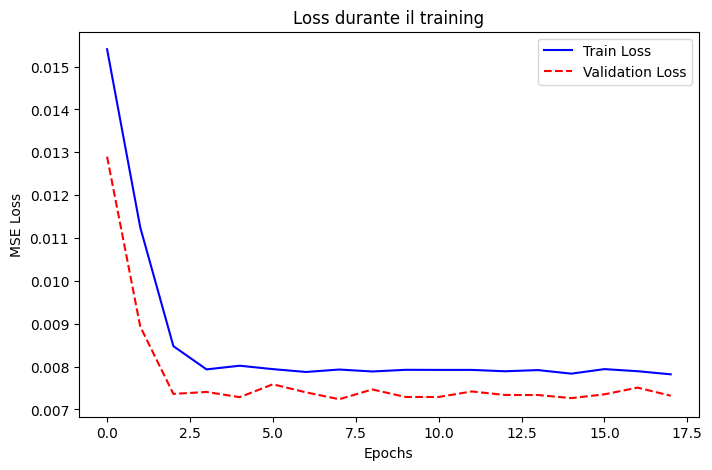

Grafico Loss salvato in lstm_test_1/loss_plot.png


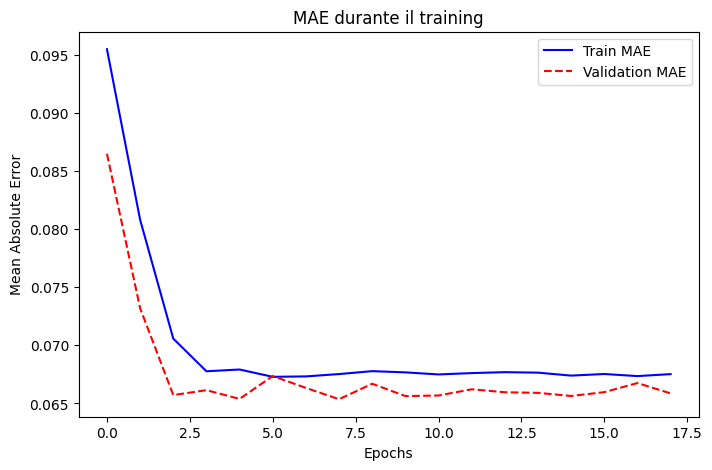

Grafico MAE salvato in lstm_test_1/mae_plot.png


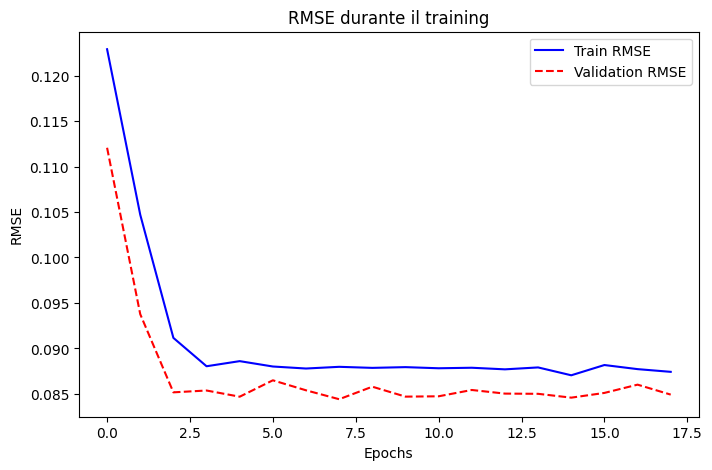

Grafico RMSE salvato in lstm_test_1/rmse_plot.png


In [11]:
lstm_model.plot_training_history()

In [12]:
lstm_model.evaluate(X_test, y_test)

Metriche salvate in lstm_test_1/evaluation_metrics.csv


{'MSE': 0.0070240339050589825,
 'RMSE': 0.08380950963380578,
 'MAE': 0.06393383901862838,
 'R2': 0.6039274699563915}

In [13]:
y_pred = lstm_model.predict(X_test)  
comparison_df = lstm_model.compare_predictions(y_test, y_pred)  

Confronto predizioni salvato in lstm_test_1/predictions_comparison.csv


In [14]:
lstm_model.plot_predictions(y_test, y_pred, 50)

Grafico salvato in lstm_test_1/predictions_plot_1.png
Grafico salvato in lstm_test_1/predictions_plot_2.png
Grafico salvato in lstm_test_1/predictions_plot_tot.png


In [15]:
lstm_model.save_model()

Modello salvato in lstm_test_1/lstm_model.h5


In [16]:
lstm_model.save_summary()

Sommario del modello salvato in lstm_test_1/model_summary.txt


In [17]:
lstm_model.save_training_history()

Training history salvata in lstm_test_1/training_history.npy
